<a href="https://colab.research.google.com/github/RVasconcelosMiguel/ComputerVision/blob/main/CV_Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
pip install tqdm

In [61]:
import cv2
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm  # Importar tqdm

import os
import pandas as pd
import json

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.autograd import Variable
from torch.optim import Adam, SGD, NAdam
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler


import torchvision
from torchvision import models, transforms
from torchvision.io import read_image

from torchsummary import summary

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from PIL import Image
import zipfile

In [62]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The model will be running on", device, "device")

The model will be running on cpu device


In [63]:
import zipfile

#Limpa arquivos existentes do sistema antes de iniciar as operações.
!rm -f -r "images"
!rm -f "module_metadada.json"

#Definição de caminhos
download_path = "/content/InfraredSolarModules/"
download_path_file = "/content/InfraredSolarModules/2020-02-14_InfraredSolarModules.zip"
zip_path = "/content/2020-02-14_InfraredSolarModules.zip"
extract_path = "/content"

# Clonar o repositorio e fazer unzip
!git clone https://github.com/RaptorMaps/InfraredSolarModules.git $download_path
!mv $download_path_file $extract_path
!unzip -uq $zip_path -d $extract_path

# Imagens
image_folder_path = "/content/InfraredSolarModules/images"
!mv $image_folder_path $extract_path

# module_metadata.json
metadata_file_path = "/content/InfraredSolarModules/module_metadata.json"
!mv $metadata_file_path $extract_path

#Remoção de arquivos desnecessários
!rm -f $zip_path
!rm -f -r $download_path
!rm -r "__MACOSX"

Cloning into '/content/InfraredSolarModules'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 24 (delta 10), reused 12 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (24/24), 5.49 MiB | 9.33 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [64]:
classes_a = ("anomaly", "no-anomaly")
classes_b=("cell","cell-multi","cracking","hotspot","hot-spot-multi","shadowing","diode","diode-multi","vegetation","soiling","offlinemodule")
classes_c=("cell","cell-multi","cracking","hotspot","hot-spot-multi","shadowing","diode","diode-multi","vegetation","soiling","offlinemodule","no-anomaly")


metadata_path = '/content/module_metadata.json'
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

metadata_df_a = pd.DataFrame.from_dict(metadata, orient='index')
metadata_df_b = pd.DataFrame.from_dict(metadata, orient='index')
metadata_df_c = pd.DataFrame.from_dict(metadata, orient='index')

metadata_df_a['anomaly_class'] = metadata_df_a['anomaly_class'].apply(lambda x: 'Anomaly' if x != 'No-Anomaly' else 'No-Anomaly')
metadata_df_b = metadata_df_b[metadata_df_b["anomaly_class"] != "No-Anomaly"]

print("---------a) dataframe------------")
print("\n Data \n",metadata_df_a.tail(10))
print("\n Data size :",metadata_df_a.shape[0])
print("\n")

print("---------b) dataframe------------")
print("\n Data \n",metadata_df_b.tail(10))
print("\n Data size :",metadata_df_b.shape[0])
print("\n")

print("---------c) dataframe------------")
print("\n Data \n",metadata_df_c.tail(10))
print("\n Data size :",metadata_df_c.shape[0])
print("\n")

---------a) dataframe------------

 Data 
          image_filepath anomaly_class
8483    images/8483.jpg       Anomaly
8484    images/8484.jpg       Anomaly
8485    images/8485.jpg       Anomaly
8486    images/8486.jpg       Anomaly
8487    images/8487.jpg       Anomaly
8488    images/8488.jpg       Anomaly
8489    images/8489.jpg       Anomaly
7464    images/7464.jpg       Anomaly
18065  images/18065.jpg    No-Anomaly
13354  images/13354.jpg    No-Anomaly

 Data size : 20000


---------b) dataframe------------

 Data 
        image_filepath anomaly_class
8481  images/8481.jpg    Vegetation
8482  images/8482.jpg    Vegetation
8483  images/8483.jpg    Vegetation
8484  images/8484.jpg    Vegetation
8485  images/8485.jpg    Vegetation
8486  images/8486.jpg    Vegetation
8487  images/8487.jpg    Vegetation
8488  images/8488.jpg    Vegetation
8489  images/8489.jpg    Vegetation
7464  images/7464.jpg      Cracking

 Data size : 10000


---------c) dataframe------------

 Data 
          imag

In [65]:
#NO-Anomaly=0 Anomalia=1
metadata_df_a['anomaly_class'] = metadata_df_a['anomaly_class'].apply(lambda x: 1 if x != 'No-Anomaly' else 0)# as anomalias ficam todas Anomaly
print("*************** Alinea a dataframe ***************")
print("\n Dados \n",metadata_df_a.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_a.shape[0])
print("\n")

metadata_df_b['anomaly_class'] = metadata_df_b['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11
)
print("*************** Alinea b dataframe ***************")
print("\n Dados \n",metadata_df_b.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_b.shape[0])
print("\n")

metadata_df_c['anomaly_class'] = metadata_df_c['anomaly_class'].apply(
    lambda x: 0 if x == 'Cell'
              else 1 if x == 'Cell-Multi'
              else 2 if x == 'Cracking'
              else 3 if x == 'Hot-Spot'
              else 4 if x == 'Hot-Spot-Multi'
              else 5 if x == 'Shadowing'
              else 6 if x == 'Diode'
              else 7 if x == 'Diode-Multi'
              else 8 if x == 'Vegetation'
              else 9 if x == 'Soiling'
              else 10 if x == 'Offline-Module'
              else 11 if x == 'No-Anomaly'
              else 12
)
print("*************** Alinea c dataframe ***************")
print("\n Dados \n",metadata_df_c.head(20)) # Verificar as primeiras linhas
print("\n numero de linhas :",metadata_df_c.shape[0])
print("\n")

*************** Alinea a dataframe ***************

 Dados 
          image_filepath  anomaly_class
13357  images/13357.jpg              0
13356  images/13356.jpg              0
19719  images/19719.jpg              0
11542  images/11542.jpg              0
11543  images/11543.jpg              0
11540  images/11540.jpg              0
11541  images/11541.jpg              0
11546  images/11546.jpg              0
11547  images/11547.jpg              0
11544  images/11544.jpg              0
11545  images/11545.jpg              0
14545  images/14545.jpg              0
11548  images/11548.jpg              0
11549  images/11549.jpg              0
16426  images/16426.jpg              0
19927  images/19927.jpg              0
5988    images/5988.jpg              1
5989    images/5989.jpg              1
19399  images/19399.jpg              0
19398  images/19398.jpg              0

 numero de linhas : 20000


*************** Alinea b dataframe ***************

 Dados 
        image_filepath  anomaly

In [66]:
train_data, test_data=train_test_split(metadata_df_a, test_size=0.15,train_size=0.85, random_state=2, stratify=metadata_df_a["anomaly_class"])
train_data.reset_index(drop=True, inplace=True)
test_data.reset_index(drop=True, inplace=True)

ESTÁ IGUAL AO DO VITOR TEMOS QUE MUDAR DAQUI PARA BAIXO

In [100]:
class MyImageDataset(data.Dataset):
    def __init__(self, metadata, transform=None):
        self.img_labels = metadata["anomaly_class"].values
        self.img_paths = metadata["image_filepath"].values
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):#posteriormente o dataloader vai passar por todos os idx
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert("L") # Abrir a imagem como RGB
        label = self.img_labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)


In [101]:
# Transformações
transform = transforms.Compose([

    transforms.ToTensor(),  # Converte para tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # Normaliza
])

# Datasets
train_dataset = MyImageDataset(metadata=train_data, transform=transform)
test_dataset = MyImageDataset(metadata=test_data, transform=transform)

# DataLoaders
batch_size = 32
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



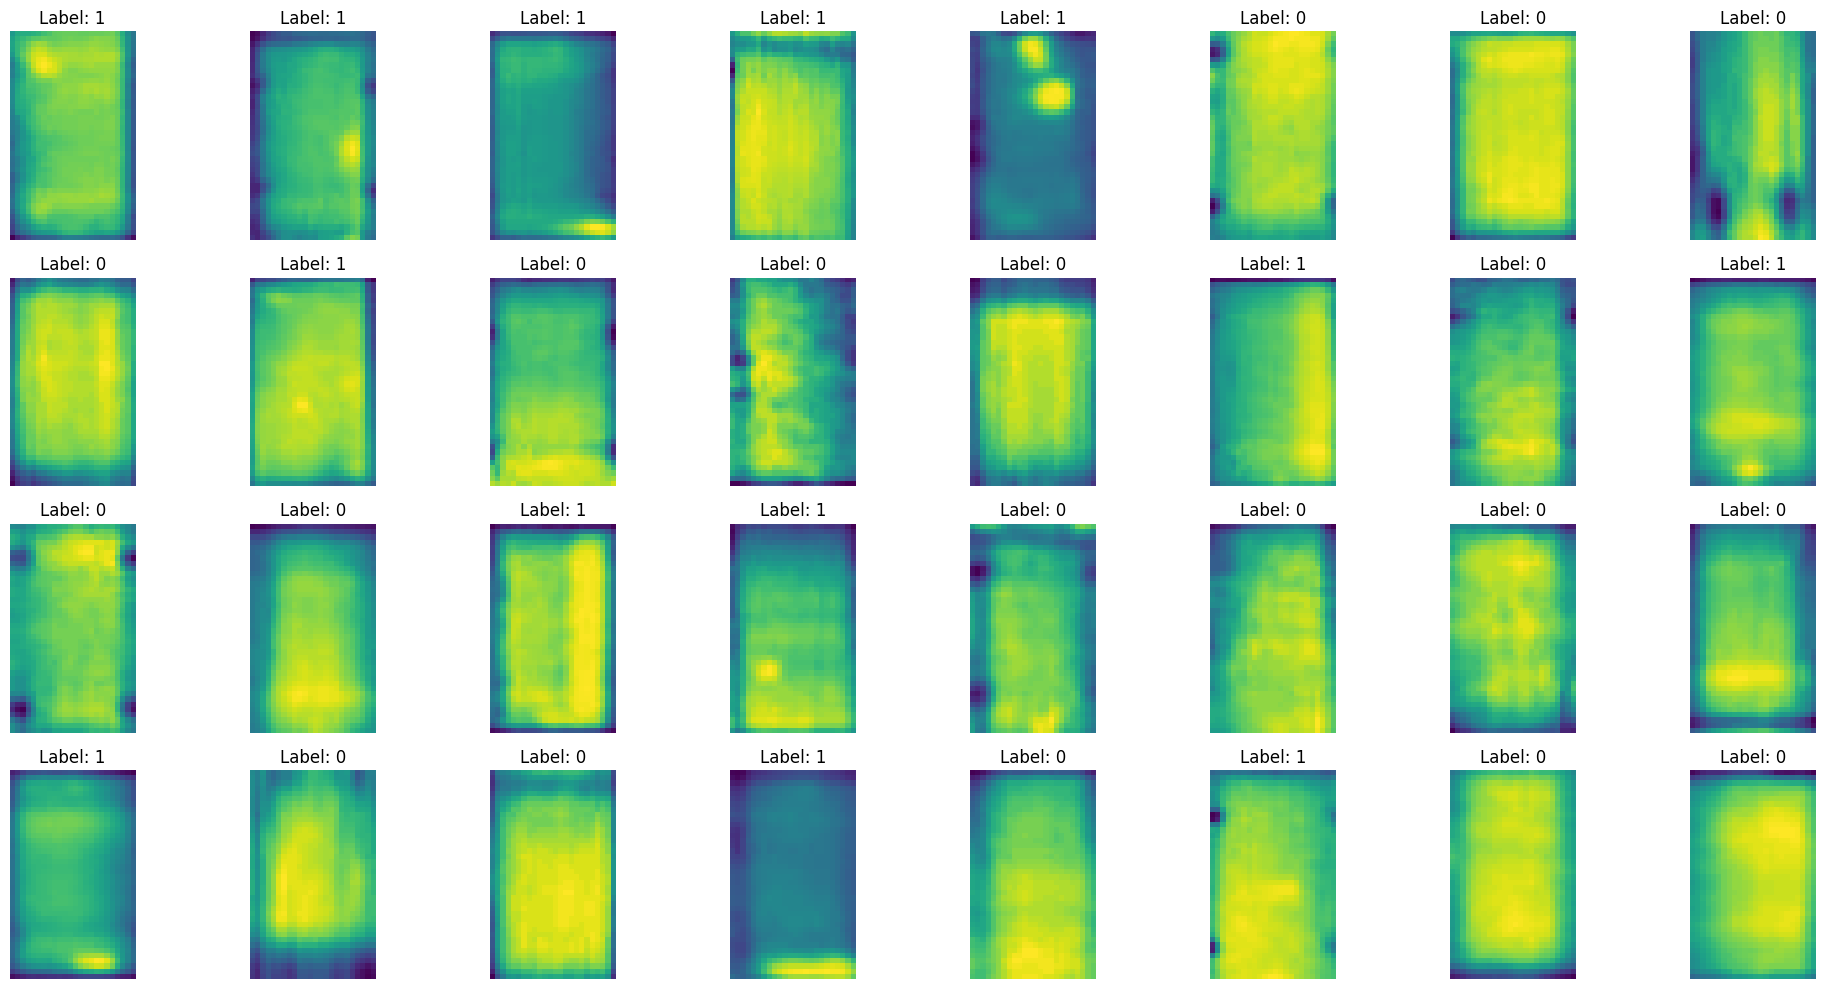

In [102]:
# Obtém um batch de imagens, seus rótulos e os caminhos
images, labels = next(iter(train_loader))  # Pega o primeiro batch

# Desfazendo a normalização para as imagens
images = images * 0.5 + 0.5  # Inverte a normalização, para voltar ao intervalo [0, 1]

# Cria uma figura com múltiplos subplots
fig, axes = plt.subplots(4, 8, figsize=(20, 10))  # 4 linhas e 8 colunas
axes = axes.flatten()  # Para facilitar o acesso aos eixos (axes)

# Loop para exibir as 32 primeiras imagens do batch
for i in range(len(images)):
    image = images[i]  # Pega a i-ésima imagem do batch
    image_pil = transforms.ToPILImage()(image)  # Converte o tensor para uma imagem PIL

    # Exibe a imagem
    axes[i].imshow(image_pil)
    axes[i].set_title(f"Label: {labels[i].item()}")  # Exibe o rótulo e o caminho do arquivo
    axes[i].axis('off')  # Remove os eixos para uma exibição mais limpa

plt.tight_layout()  # Ajusta o layout para que as imagens não se sobreponham
plt.show()





